# Detect and track players, ball and referee in football match using `YOLO v11`, `roboflow` and `supervision` packages.

- Using `roboflow` to create dataset
- Using `YOLO` to train model and detect players and ball
- Using `supervision` to visualize boxes around detected objects and set label for them
---

### Install pytorch compatible with `CUDA`
#### First of all, download and install `CUDA toolkit` compatible with your Nvidia graphics card from [this link](https://developer.nvidia.com/cuda-downloads)
#### Then Install `CUDNN` from [this link](https://developer.nvidia.com/cudnn-downloads)

#### Then install `pytorch` from [this guid](https://pytorch.org/get-started/locally/):

![installing pytorch compatible to CUDA platform](/docs/images/torch.png)

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

---
### Verify Nvidia is accessible
the result of this command should be like this:
```
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.70                 Driver Version: 572.70         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   42C    P8              1W /   43W |      18MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+------------------------+----------------------+
```

In [1]:
!nvidia-smi

Sun Mar 23 14:25:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.70                 Driver Version: 572.70         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8              1W /   40W |       0MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

-----
### install required packages

In [ ]:
!pip install -q ultralytics roboflow supervision opencv-python numpy
!pip install git+https://github.com/roboflow/sports.git

---
### Download ball, players and referee detection dataset from [this link](https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc)

![player_dataset](/docs/images/player_dataset.png)

---
### Download base model of `YOLO` form [this link](https://docs.ultralytics.com/tasks/detect/#models)
![models image](/docs/images/yolo.png)
#### I used `YOLO11s`
> You can skip the YOLO model download section.
> When using the model defined in the code, if it has not been downloaded, it will be downloaded automatically.

---
### Imports

In [2]:
import cv2
import os
import numpy as np
import torch
from ultralytics import YOLO
from tqdm import tqdm
from sports.common.team import TeamClassifier
import supervision as sv

---
### Predefined Variables

In [3]:
HOME = os.getcwd()
print(torch.cuda.is_available())
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

True


#### The result of the print show that the CUDA is accessible or not
> if you have installed all necessary apps and packages based on this guid, you have to access the cuda!

---
### Train model to detect `players`, `ball` and `referee`

In [ ]:
base_model = YOLO(f'{HOME}/yolo12s.pt')
base_model.train(data=f"{HOME}/football/data.yaml", epochs=50, batch=4, imgsz=1280, plots=True, device=DEVICE)

#### Our Model Trained Path
##### Go to the `/runs/detect/` directory to see the trained model directory.
> [!IMPORTANT]
> Attention: Every time you train the model, a new directory in `/runs/detect/` will be created, even if you cancel training process! so be careful to define the path of trained model!

In [4]:
OUR_MODEL_PATH = f'{HOME}/runs/detect/trainv11s/weights/best.pt'

##### Define source video path to detect players, referees and ball in it.

In [5]:
SOURCE_VIDEO_PATH = f"{HOME}/clips/download3.mp4"

--------
### Validate trained model

In [ ]:
model = YOLO(OUR_MODEL_PATH)
model.val(data=f'{HOME}/football/data.yaml', imgsz=1280, device=DEVICE)

---
### You can download some football match clips form this links

- https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF
- https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf
- https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-
- https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU
- https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu

---
### Object IDs (Class IDs)

In [6]:
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

---
### Detect `players`, `ball` and `referee` just using `YOLO`

In [ ]:
model = YOLO(OUR_MODEL_PATH)
result = model(source=SOURCE_VIDEO_PATH, show=True, conf=0.4, save=False, device=DEVICE)

---
### Collect Crops Of Players
#### To separate the two teams we need to crop the players' pictures.

In [7]:
STRIDE = 30


def extract_crops(source_video_path: str):
    frame_generator = sv.get_video_frames_generator(source_video_path, stride=STRIDE)
    yolo_model = YOLO(OUR_MODEL_PATH)

    crops = []
    for frame in tqdm(frame_generator, desc="Extracting crops..."):
        results = yolo_model(frame, conf=0.3, save=False, device=DEVICE, verbose=False, half=True)[0]
        detections = sv.Detections.from_ultralytics(results)
        detections = detections[detections.class_id == PLAYER_ID]
        detections = detections.with_nms(threshold=0.5, class_agnostic=True)
        crops += [
            sv.crop_image(frame, xyxy)
            for xyxy in detections.xyxy
        ]
    return crops


In [8]:
crops = extract_crops(SOURCE_VIDEO_PATH)

Extracting crops...: 25it [00:01, 12.57it/s]


In [9]:
len(crops)

491

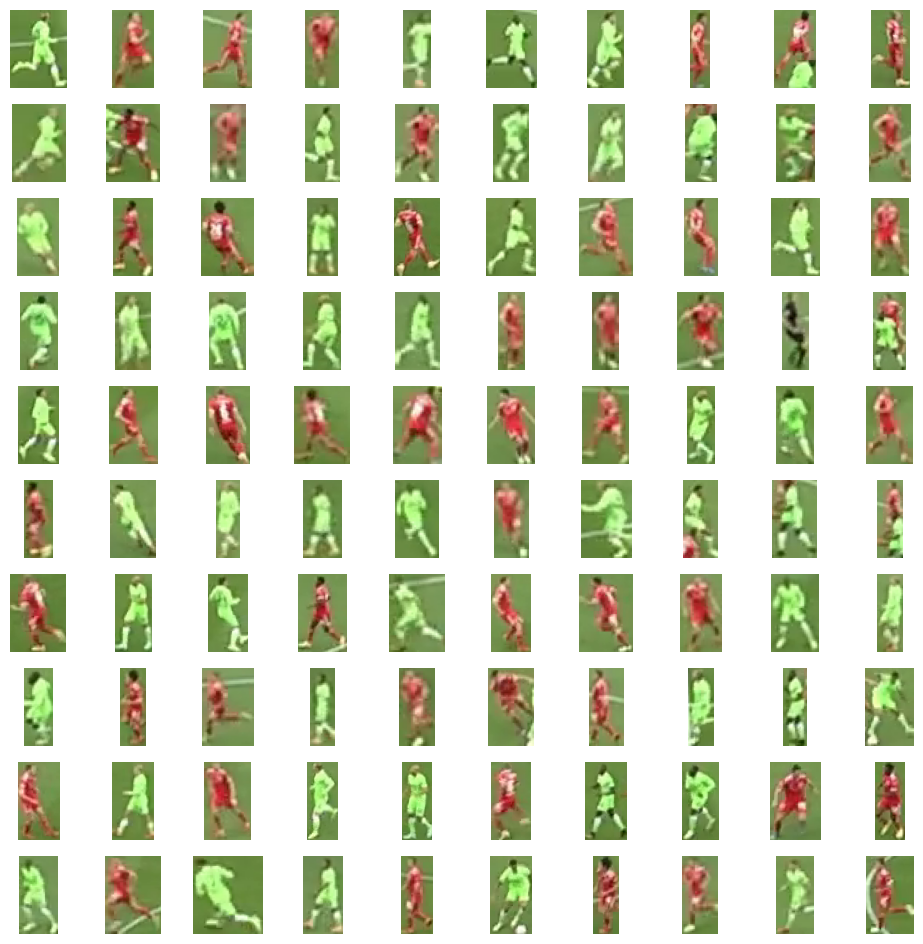

In [10]:
sv.plot_images_grid(crops[:100], grid_size=(10, 10))

---
### Team Classification

In [11]:
def resolve_goalkeepers_team_id(players: sv.Detections, goalkeepers: sv.Detections):
    goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    team_0_centroid = players_xy[players.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)
    goalkeepers_team_id = []
    for goalkeeper_xy in goalkeepers_xy:
        dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
        goalkeepers_team_id.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeepers_team_id)

### First Frame Result

Extracting crops...: 25it [00:01, 16.23it/s]
Embedding extraction: 16it [00:03,  4.25it/s]
Embedding extraction: 1it [00:00,  6.37it/s]


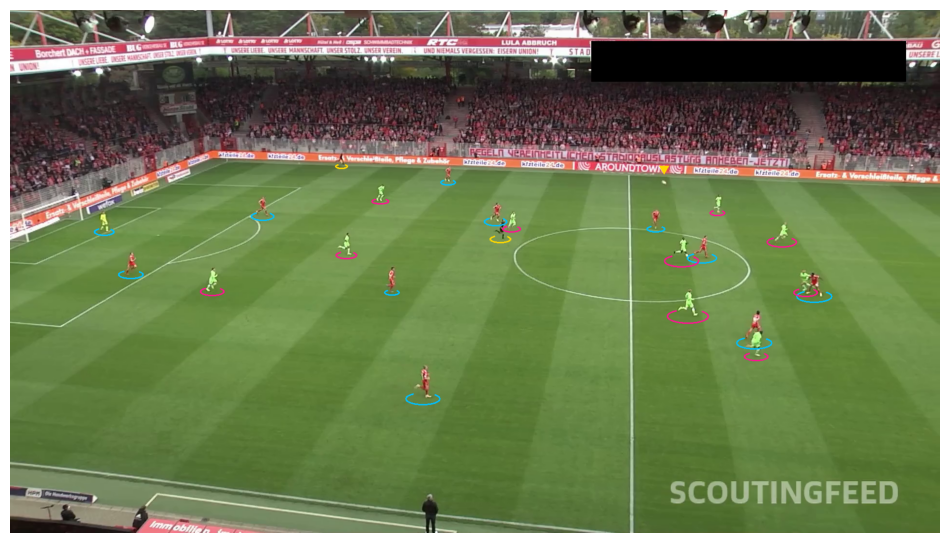

In [12]:
crops = extract_crops(SOURCE_VIDEO_PATH)
team_classifier = TeamClassifier(device=DEVICE)
team_classifier.fit(crops)

yolo_model = YOLO(OUR_MODEL_PATH)

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)

triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20,
    height=17,
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

results = yolo_model(frame, conf=0.4, save=False, device=DEVICE, verbose=False, half=True)[0]

detections = sv.Detections.from_ultralytics(results)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nmm(threshold=0.5, class_agnostic=True)

players_detections = all_detections[all_detections.class_id == PLAYER_ID]
goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)
referees_detections.class_id -= 1

all_detections = sv.Detections.merge([players_detections, goalkeepers_detections, referees_detections])

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=all_detections)
annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=ball_detections)
sv.plot_image(annotated_frame)


### Clip Result

In [ ]:
crops = extract_crops(SOURCE_VIDEO_PATH)
team_classifier = TeamClassifier(device=DEVICE)
team_classifier.fit(crops)

yolo_model = YOLO(OUR_MODEL_PATH)

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)

triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20,
    height=17,
)

TARGET_VIDEO_PATH = f"{HOME}/result_clips/result_team_classification.mp4"

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        results = yolo_model(frame, conf=0.4, save=False, device=DEVICE, verbose=False, half=True)[0]

        detections = sv.Detections.from_ultralytics(results)

        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nmm(threshold=0.5, class_agnostic=True)

        players_detections = all_detections[all_detections.class_id == PLAYER_ID]
        goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
        referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

        players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
        players_detections.class_id = team_classifier.predict(players_crops)

        goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)
        referees_detections.class_id -= 1

        all_detections = sv.Detections.merge([players_detections, goalkeepers_detections, referees_detections])

        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=all_detections)
        annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=ball_detections)

        video_sink.write_frame(annotated_frame)


<img src="https://github.com/salehghotbani/Football_Yolo11_Supervision_Roboflow/raw/main/docs/clips/result_team_classification.gif" alt="Result Team Classification" width="100%">

---
## Pitch keypoint detector
### Train model:

In [ ]:
pose_model = YOLO(f"{HOME}/yolo11x-pose.pt")
pose_model.train(data=f"{HOME}/fieldDetection/data.yaml", task='pose', epochs=12, batch=40, imgsz=640, mosaic=0.0,
                 plots=True, device=DEVICE)

> Attention: Every time you train the model, a new directory in `/runs/pose/` will be created, even if you cancel training process! so be careful to define the path of trained model!

In [13]:
PITCH_KEYPOINTS_MODEL_PATH = f'{HOME}/runs/pose/trainv8x/weights/best.pt'

### Validate Trained model

In [ ]:
model_trained = YOLO(PITCH_KEYPOINTS_MODEL_PATH)
model_trained.val(data=f"{HOME}/fieldDetection/data.yaml", task='pose', imgsz=640, device=DEVICE)

---
## Pose estimation of football pitch
#### First Frame


0: 384x640 1 pitch, 79.4ms
Speed: 2.1ms preprocess, 79.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


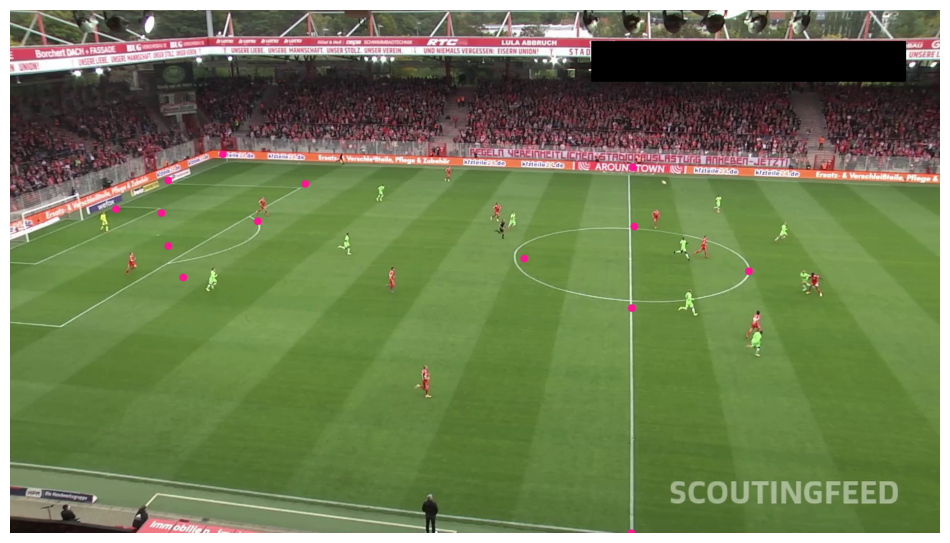

In [14]:
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

yolo_pitch_keypoint_model = YOLO(PITCH_KEYPOINTS_MODEL_PATH)
result = yolo_pitch_keypoint_model(frame, conf=0.3)[0]

key_points = sv.KeyPoints.from_ultralytics(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_generator_key_points = sv.KeyPoints(xy=frame_reference_points[np.newaxis])

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(annotated_frame, frame_generator_key_points)

sv.plot_image(annotated_frame)

In [15]:
key_points.confidence[0]

array([    0.97451,     0.89337,     0.62563,     0.07241,   0.0082229,    0.001862,      0.8852,     0.25003,     0.88763,      0.9976,     0.99191,     0.92873,     0.40645,     0.99643,     0.99754,     0.99783,     0.97542,    0.095282,    0.033076,   0.0044771,  0.00019928,   0.0035597,   0.0028935,  8.9798e-05,
           0.02282,   0.0033835,  0.00072733,  2.8099e-05,  2.4251e-05,  8.0441e-05,     0.99956,     0.96724], dtype=float32)

### Video Result of pose estimation of football pitch

In [ ]:
yolo_pitch_keypoint_model = YOLO(PITCH_KEYPOINTS_MODEL_PATH)

vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8
)

TARGET_VIDEO_PATH = f"{HOME}/result_clips/result_pitch2.mp4"

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        results = yolo_pitch_keypoint_model(frame, conf=0.3, save=False, device=DEVICE)[0]

        key_points = sv.KeyPoints.from_ultralytics(results)
        if not key_points.confidence is None:
            filter = key_points.confidence[0] > 0.5
            frame_reference_points = key_points.xy[0][filter]
            frame_reference_key_points = sv.KeyPoints(xy=frame_reference_points[np.newaxis, ...])

            annotated_frame = frame.copy()
            annotated_frame = vertex_annotator.annotate(scene=annotated_frame, key_points=frame_reference_key_points)

            video_sink.write_frame(annotated_frame)
        else:
            video_sink.write_frame(frame)


#### Football pitch in sports package

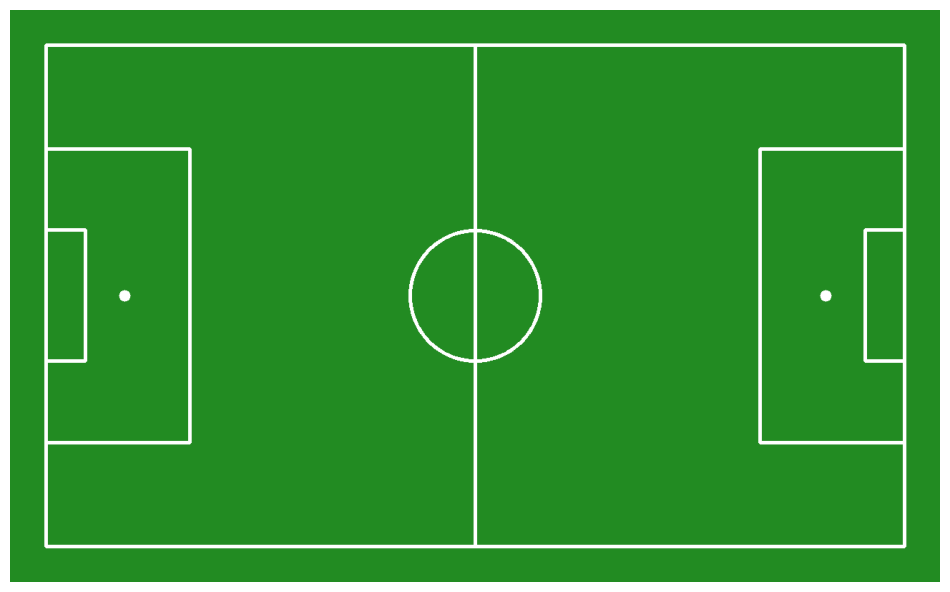

In [17]:
from sports.annotators.soccer import draw_pitch
from sports.configs.soccer import SoccerPitchConfiguration

CONFIG = SoccerPitchConfiguration()

annotated_frame = draw_pitch(CONFIG)

sv.plot_image(annotated_frame)


0: 384x640 1 pitch, 32.4ms
Speed: 1.9ms preprocess, 32.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


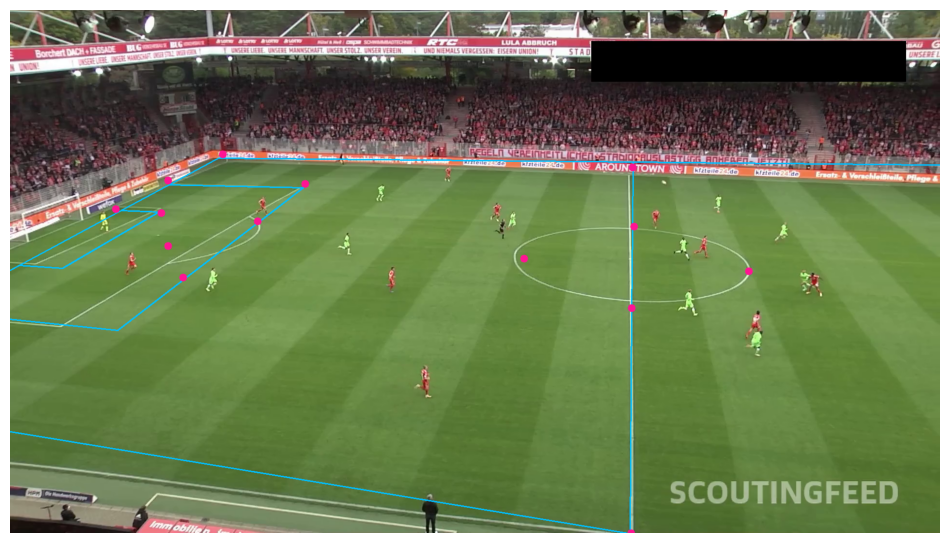

In [18]:
from sports.common.view import ViewTransformer

vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8
)
edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    thickness=2,
    edges=CONFIG.edges
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

yolo_pitch_keypoint_model = YOLO(PITCH_KEYPOINTS_MODEL_PATH)
result = yolo_pitch_keypoint_model(frame, conf=0.4)[0]

key_points = sv.KeyPoints.from_ultralytics(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(xy=frame_reference_points[np.newaxis, ...])

pitch_reference_pointsd = np.array(CONFIG.vertices)[filter]

view_transformer = ViewTransformer(
    source=pitch_reference_pointsd,
    target=frame_reference_points
)

pitch_all_points = np.array(CONFIG.vertices)
frame_all_points = view_transformer.transform_points(pitch_all_points)
frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = edge_annotator.annotate(annotated_frame, frame_all_key_points)
annotated_frame = vertex_annotator.annotate(annotated_frame, frame_reference_key_points)

sv.plot_image(annotated_frame)

### Video Result

In [ ]:
yolo_pitch_keypoint_model = YOLO(PITCH_KEYPOINTS_MODEL_PATH)

vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8
)
edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    thickness=2,
    edges=CONFIG.edges
)

TARGET_VIDEO_PATH = f"{HOME}/result_clips/result_pitch3.mp4"

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        result = yolo_pitch_keypoint_model(frame, conf=0.3, save=False, device=DEVICE)[0]

        key_points = sv.KeyPoints.from_ultralytics(result)

        if not key_points.confidence is None:
            filter = key_points.confidence[0] > 0.5
            frame_reference_points = key_points.xy[0][filter]
            frame_reference_key_points = sv.KeyPoints(xy=frame_reference_points[np.newaxis, ...])

            pitch_reference_pointsd = np.array(CONFIG.vertices)[filter]

            view_transformer = ViewTransformer(
                source=pitch_reference_pointsd,
                target=frame_reference_points
            )

            pitch_all_points = np.array(CONFIG.vertices)
            frame_all_points = view_transformer.transform_points(pitch_all_points)
            frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])

            annotated_frame = frame.copy()
            annotated_frame = edge_annotator.annotate(annotated_frame, frame_all_key_points)
            annotated_frame = vertex_annotator.annotate(annotated_frame, frame_reference_key_points)

            video_sink.write_frame(annotated_frame)
        else:
            video_sink.write_frame(frame)


---
## Show Players, ball and referees on the pitch
### First Frame

Extracting crops...: 25it [00:01, 15.84it/s]
Embedding extraction: 16it [00:03,  4.29it/s]



0: 736x1280 1 ball, 2 goalkeepers, 20 players, 2 referees, 42.1ms
Speed: 4.5ms preprocess, 42.1ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.57it/s]


0: 384x640 1 pitch, 26.3ms


Speed: 1.4ms preprocess, 26.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


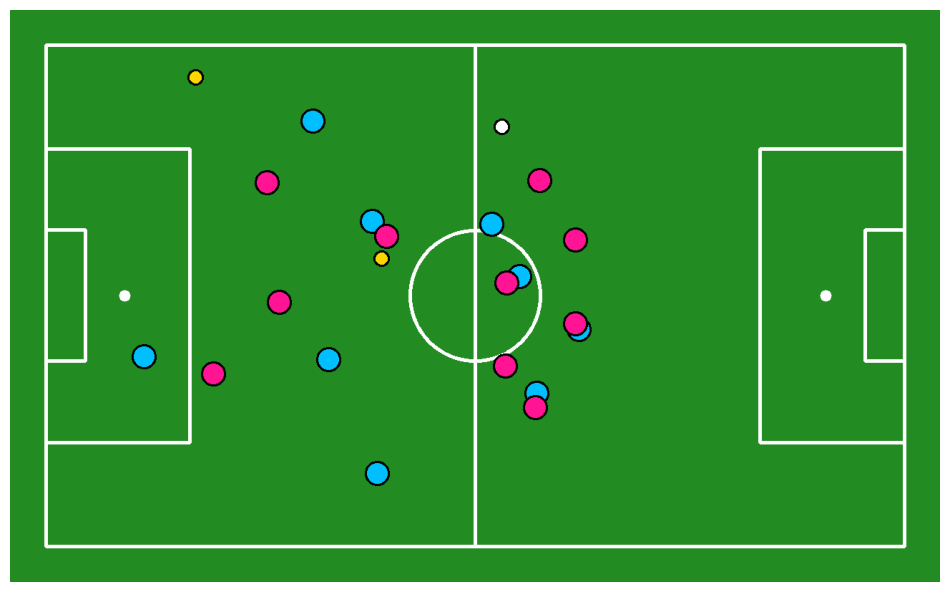

In [19]:
from sports.annotators.soccer import draw_pitch, draw_points_on_pitch

crops = extract_crops(SOURCE_VIDEO_PATH)
team_classifier = TeamClassifier(device=DEVICE)
team_classifier.fit(crops)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

yolo_model = YOLO(OUR_MODEL_PATH)
results = yolo_model(frame, conf=0.4, save=False, device=DEVICE)[0]

detections = sv.Detections.from_ultralytics(results)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nmm(threshold=0.5, class_agnostic=True)

players_detections = all_detections[all_detections.class_id == PLAYER_ID]
goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)

result = yolo_pitch_keypoint_model(frame, conf=0.4)[0]

key_points = sv.KeyPoints.from_ultralytics(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(xy=frame_reference_points[np.newaxis, ...])

pitch_reference_points = np.array(CONFIG.vertices)[filter]

view_transformer = ViewTransformer(
    source=frame_reference_points,
    target=pitch_reference_points
)

frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_ball_xy = view_transformer.transform_points(frame_ball_xy)

frame_players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_players_xy = view_transformer.transform_points(frame_players_xy)

frame_referees_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_referees_xy = view_transformer.transform_points(frame_referees_xy)

pitch = draw_pitch(config=CONFIG)
pitch = draw_points_on_pitch(config=CONFIG,
                             xy=pitch_ball_xy,
                             face_color=sv.Color.WHITE,
                             edge_color=sv.Color.BLACK,
                             radius=10,
                             pitch=pitch
                             )
pitch = draw_points_on_pitch(config=CONFIG,
                             xy=pitch_players_xy[players_detections.class_id == 0],
                             face_color=sv.Color.from_hex('#00BFFF'),
                             edge_color=sv.Color.BLACK,
                             radius=16,
                             pitch=pitch
                             )
pitch = draw_points_on_pitch(config=CONFIG,
                             xy=pitch_players_xy[players_detections.class_id == 1],
                             face_color=sv.Color.from_hex('#FF1493'),
                             edge_color=sv.Color.BLACK,
                             radius=16,
                             pitch=pitch
                             )
pitch = draw_points_on_pitch(config=CONFIG,
                             xy=pitch_referees_xy,
                             face_color=sv.Color.from_hex('#FFD700'),
                             edge_color=sv.Color.BLACK,
                             radius=10,
                             pitch=pitch
                             )

sv.plot_image(pitch)

### Video Result

In [ ]:
crops = extract_crops(SOURCE_VIDEO_PATH)
team_classifier = TeamClassifier(device=DEVICE)
team_classifier.fit(crops)

yolo_model = YOLO(OUR_MODEL_PATH)

TARGET_VIDEO_PATH = f"{HOME}/result_clips/result_pitch.mp4"

fourcc = cv2.VideoWriter_fourcc(*'MJPG')
fps = video_info.fps
out = cv2.VideoWriter(TARGET_VIDEO_PATH, fourcc, fps, (1280, 720))

with sv.VideoSink(target_path=TARGET_VIDEO_PATH, video_info=video_info, codec='MJPEG'):
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        results = yolo_model(frame, conf=0.4, save=False, device=DEVICE, verbose=False, half=True)[0]

        detections = sv.Detections.from_ultralytics(results)

        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nmm(threshold=0.5, class_agnostic=True)

        players_detections = all_detections[all_detections.class_id == PLAYER_ID]
        goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
        referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

        players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
        players_detections.class_id = team_classifier.predict(players_crops)

        goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)

        result = yolo_pitch_keypoint_model(frame, conf=0.4, save=False, device=DEVICE, verbose=False, half=True)[0]

        key_points = sv.KeyPoints.from_ultralytics(result)

        filter = key_points.confidence[0] > 0.5
        frame_reference_points = key_points.xy[0][filter]
        frame_reference_key_points = sv.KeyPoints(xy=frame_reference_points[np.newaxis, ...])

        pitch_reference_points = np.array(CONFIG.vertices)[filter]

        view_transformer = ViewTransformer(source=frame_reference_points, target=pitch_reference_points)

        frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_ball_xy = view_transformer.transform_points(frame_ball_xy)

        frame_players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_players_xy = view_transformer.transform_points(frame_players_xy)

        frame_referees_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_referees_xy = view_transformer.transform_points(frame_referees_xy)

        pitch = draw_pitch(config=CONFIG)
        pitch = draw_points_on_pitch(config=CONFIG,
                                     xy=pitch_ball_xy,
                                     face_color=sv.Color.WHITE,
                                     edge_color=sv.Color.BLACK,
                                     radius=10,
                                     pitch=pitch
                                     )
        pitch = draw_points_on_pitch(config=CONFIG,
                                     xy=pitch_players_xy[players_detections.class_id == 0],
                                     face_color=sv.Color.from_hex('#00BFFF'),
                                     edge_color=sv.Color.BLACK,
                                     radius=16,
                                     pitch=pitch
                                     )
        pitch = draw_points_on_pitch(config=CONFIG,
                                     xy=pitch_players_xy[players_detections.class_id == 1],
                                     face_color=sv.Color.from_hex('#FF1493'),
                                     edge_color=sv.Color.BLACK,
                                     radius=16,
                                     pitch=pitch
                                     )
        pitch = draw_points_on_pitch(config=CONFIG,
                                     xy=pitch_referees_xy,
                                     face_color=sv.Color.from_hex('#FFD700'),
                                     edge_color=sv.Color.BLACK,
                                     radius=16,
                                     pitch=pitch
                                     )

        resized_frame = cv2.resize(pitch, (1280, 720))

        out.write(resized_frame)


<img src="https://github.com/salehghotbani/Football_Yolo11_Supervision_Roboflow/raw/main/docs/clips/result_pitch.gif" alt="Result Team Classification" width="100%">